<a href="https://colab.research.google.com/github/doogzultz/time_series_project/blob/main/preprocessing_and_model_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
from pandas.plotting import scatter_matrix
from tensorflow.keras.layers import Layer, Dense, Dropout, Input, \
Flatten, Concatenate, Conv1D, LSTM, Bidirectional, BatchNormalization, Activation, TimeDistributed, Lambda, MaxPooling1D, GRU
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import shuffle
#from sklearn.compose import ColumnTransformer
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import GridSearchCV, train_test_split
#from sklearn.linear_model import LogisticRegression, LinearRegression
#from sklearn.svm import SVC
#from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

In [26]:
class g:
  window_size = 8
  batch_size = 16
  valid_size = .1
  test_size = .1
  test = False

In [27]:
url = "https://raw.githubusercontent.com/doogzultz/time_series_project/main/data.csv"
data = pd.read_csv(url)

In [28]:
data.columns

Index(['date', 'identifier', 'market_cap', 'sector', 'index_membership',
       'factor_1', 'factor_2', 'factor_3', 'factor_4', 'factor_5', 'factor_6',
       'factor_7', 'factor_8', 'factor_9', 'factor_10', 'target'],
      dtype='object')

In [29]:
data.drop(columns = 'index_membership', inplace = True)

In [30]:
data.sort_values(by = ['identifier', 'date'], inplace = True)
data.head()
data.shape

(32202, 15)

In [31]:
(data== 0).sum(axis=0)

date           0
identifier     0
market_cap     0
sector         0
factor_1       0
factor_2      68
factor_3       0
factor_4       0
factor_5       0
factor_6       0
factor_7       0
factor_8       0
factor_9      68
factor_10      0
target        68
dtype: int64

In [32]:
ident_counts= data.value_counts('identifier')
ident_counts

identifier
AD41WBQFVG43    104
UZ4DWDZ8ALZ4    104
KR47536Y10D4    104
KPJ8FTV9ESJ3    104
KMHQ727PU8E2    104
               ... 
PNUM57CYEB27      5
KHKNKSMXBWP3      5
LYCPQJ19AOY0      5
RENR64FT3I74      5
LALJLSN9UMP2      2
Length: 356, dtype: int64

In [33]:
data.value_counts('sector', normalize = True).sort_index()

sector
10    0.049221
15    0.093162
20    0.208527
25    0.132849
30    0.072759
35    0.049003
40    0.232812
45    0.051674
50    0.038352
55    0.071642
dtype: float64

In [34]:
data[data['identifier'].isin(list(ident_counts[ident_counts.values > 24].index))].value_counts('sector', normalize = True).sort_index()

sector
10    0.048877
15    0.093273
20    0.209105
25    0.132657
30    0.072250
35    0.049284
40    0.231601
45    0.051979
50    0.038694
55    0.072281
dtype: float64

In [35]:
data[data['identifier'].isin(list(ident_counts[ident_counts.values <= 24].index))].value_counts('sector', normalize = True).sort_index()

sector
10    0.087719
15    0.080702
20    0.143860
25    0.154386
30    0.129825
35    0.017544
40    0.368421
45    0.017544
dtype: float64

In [36]:
sector_onehot = pd.get_dummies(data['sector'], prefix='sector')
sector_onehot.head()
sector_onehot.shape

(32202, 10)

In [37]:
target = data['target']
data.drop(columns = ['sector', 'target'], inplace = True)
data = pd.concat([data, sector_onehot, target], axis = 1)
data.head()
data.shape

(32202, 24)

In [38]:
import math
from math import floor as fl
ident_counts= data.value_counts('identifier')
def split_to_series(df, valid_size = g.valid_size, test_size = g.test_size,length_cutoff = 3*g.window_size, test = g.test):
  ident_counts= df.value_counts('identifier')
  df_long = df[df['identifier'].isin(list(ident_counts[ident_counts.values > length_cutoff].index))]
  df_short = df[df['identifier'].isin(list(ident_counts[(ident_counts.values <= length_cutoff) & (ident_counts.values >= 2*g.window_size)].index))]
  series_dict = {}
  train_dict = {}
  valid_dict = {}
  test_dict = {0: pd.DataFrame(columns = data.columns)}
  for i, ident in enumerate(df_long.value_counts('identifier').index):
    series_dict[i] = df_long[df_long['identifier'] == ident].sort_values('date').reset_index().drop(columns = 'index')
    if test == True:
      train_dict[i] = series_dict[i].iloc[:fl((1-valid_size - test_size)*len(series_dict[i])) - 2*g.window_size]
      valid_dict[i] = series_dict[i].iloc[fl((1-valid_size - test_size)*len(series_dict[i]))- 2*g.window_size:fl((1- test_size)*len(series_dict[i]))- g.window_size]
      test_dict[i] = series_dict[i].iloc[fl((1- test_size)*len(series_dict[i]))- g.window_size:]
    else:
      train_dict[i] = series_dict[i].iloc[:fl((1-valid_size)*len(series_dict[i])) - g.window_size]
      valid_dict[i] = series_dict[i].iloc[fl((1-valid_size)*len(series_dict[i]))- g.window_size:]
  for j, ident in enumerate(df_short.value_counts('identifier').index):
    train_dict[len(series_dict)+j] = df_short[df_short['identifier'] == ident].sort_values('date').reset_index().drop(columns = 'index')
  print(f"Number of time series to be trained and tested: {len([keys for keys in series_dict])}")
  print(f"Number of time series to be trained: {len([keys for keys in train_dict])}")
  return train_dict, valid_dict, test_dict

In [39]:
train_dict, valid_dict, test_dict = split_to_series(data)

Number of time series to be trained and tested: 331
Number of time series to be trained: 339


In [40]:
numerical_features = ['market_cap']+list(data.loc[:,'factor_1':'factor_10'].columns)+['target']
numerical_features

['market_cap',
 'factor_1',
 'factor_2',
 'factor_3',
 'factor_4',
 'factor_5',
 'factor_6',
 'factor_7',
 'factor_8',
 'factor_9',
 'factor_10',
 'target']

In [41]:
def preprocess(train_dict, valid_dict, test_dict, numerical_features):
  train_df = pd.concat(train_dict, ignore_index = True)
  t_mean = np.mean(train_df[numerical_features])
  t_std = np.std(train_df[numerical_features])
  for i in range(0,len(train_dict)):
    train_dict[i][numerical_features] = (train_dict[i][numerical_features]-t_mean)/t_std
    #train_dict[i].drop(columns = ['factor_1','factor_10']+list(data.loc[:,'factor_3':'factor_8'].columns), inplace = True)
  for i in range(0,len(valid_dict)):
    valid_dict[i][numerical_features] = (valid_dict[i][numerical_features]-t_mean)/t_std
    #valid_dict[i].drop(columns = ['factor_1','factor_10']+list(data.loc[:,'factor_3':'factor_8'].columns), inplace = True)
    try:
      test_dict[i][numerical_features] = (test_dict[i][numerical_features]-t_mean)/t_std
      #test_dict[i].drop(columns = ['factor_1','factor_10']+list(data.loc[:,'factor_3':'factor_8'].columns), inplace = True)
    except KeyError:
      continue
  return train_dict, valid_dict, test_dict


In [42]:
train_scaled, valid_scaled, test_scaled = preprocess(train_dict, valid_dict, test_dict, numerical_features)

In [43]:
train_scaled[0].columns

Index(['date', 'identifier', 'market_cap', 'factor_1', 'factor_2', 'factor_3',
       'factor_4', 'factor_5', 'factor_6', 'factor_7', 'factor_8', 'factor_9',
       'factor_10', 'sector_10', 'sector_15', 'sector_20', 'sector_25',
       'sector_30', 'sector_35', 'sector_40', 'sector_45', 'sector_50',
       'sector_55', 'target'],
      dtype='object')

In [44]:
train_scaled[322].columns

Index(['date', 'identifier', 'market_cap', 'factor_1', 'factor_2', 'factor_3',
       'factor_4', 'factor_5', 'factor_6', 'factor_7', 'factor_8', 'factor_9',
       'factor_10', 'sector_10', 'sector_15', 'sector_20', 'sector_25',
       'sector_30', 'sector_35', 'sector_40', 'sector_45', 'sector_50',
       'sector_55', 'target'],
      dtype='object')

In [45]:
def drop_final_columns(data_dict):
  for i in range(0, len(data_dict)):
    data_dict[i].drop(columns = ['date', 'identifier'], inplace = True)
  return data_dict

In [46]:
train_scaled, valid_scaled, test_scaled = \
drop_final_columns(train_scaled), drop_final_columns(valid_scaled), drop_final_columns(test_scaled)

In [47]:
windows = train_scaled[0][['target']].iloc[0:8].astype(np.float32).reset_index(drop = True).transpose().reset_index(drop = True)
windows

,0,1,2,3,4,5,6,7
0,0.032114,-1.56188,0.018313,0.029925,0.09134,0.74931,0.035262,0.032717


In [111]:
def split_datasets(data_dict, window_size = g.window_size, batch_size = g.batch_size, shuffle = True):
  static_data = data_dict[0].iloc[window_size:,:-1]
  targets = data_dict[0]['target'].iloc[window_size:]
  windows = data_dict[0][['target']].iloc[0:8].reset_index(drop = True).transpose()
  for i in range(1, len(data_dict[0])-window_size):
    window = data_dict[0][['target']].iloc[i:window_size+i].reset_index(drop = True).transpose()
    windows = pd.concat((windows, window), axis = 0)
  def make_windows(data, windows, targets, window_size = window_size):
    target = data['target'].iloc[window_size:]
    for i in range(0, len(data)-window_size):
      window = data[['target']].iloc[i:window_size+i].reset_index(drop = True).transpose()
      windows = pd.concat((windows, window), axis = 0)
    targets = pd.concat([targets, target], axis = 0)
    return windows, targets
  for i in range(1, len(data_dict)):
    static_temp = data_dict[i].iloc[window_size:,:-1]
    static_data = pd.concat([static_data, static_temp], axis = 0)
    windows, targets = make_windows(data_dict[i], windows, targets)
  return static_data.reset_index(drop= True), windows, targets.reset_index(drop= True)

In [112]:
train_static, train_windows, train_targets=split_datasets(train_scaled)

In [113]:
train_windows

,0,1,2,3,4,5,6,7
target,0.032114,-1.561880,0.018313,0.029925,0.091340,0.749310,0.035262,0.032717
target,-1.561880,0.018313,0.029925,0.091340,0.749310,0.035262,0.032717,0.014605
target,0.018313,0.029925,0.091340,0.749310,0.035262,0.032717,0.014605,-0.171568
target,0.029925,0.091340,0.749310,0.035262,0.032717,0.014605,-0.171568,0.014590
target,0.091340,0.749310,0.035262,0.032717,0.014605,-0.171568,0.014590,0.041739
...,...,...,...,...,...,...,...,...
target,0.050980,0.023261,0.046493,-0.123892,-0.123263,0.033108,-0.033242,-0.401521
target,0.023261,0.046493,-0.123892,-0.123263,0.033108,-0.033242,-0.401521,0.032539
target,0.046493,-0.123892,-0.123263,0.033108,-0.033242,-0.401521,0.032539,0.213607
target,-0.123892,-0.123263,0.033108,-0.033242,-0.401521,0.032539,0.213607,0.036824


In [114]:
train_targets

0        0.014605
1       -0.171568
2        0.014590
3        0.041739
4        0.033736
           ...   
23324    0.032539
23325    0.213607
23326    0.036824
23327    0.218964
23328    1.395111
Name: target, Length: 23329, dtype: float64

In [115]:
train_static

,market_cap,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,factor_9,...,sector_10,sector_15,sector_20,sector_25,sector_30,sector_35,sector_40,sector_45,sector_50,sector_55
0,1.876185,1.076759,-0.012542,-0.165469,-1.619026,0.640321,-0.338896,-0.280155,0.989751,0.014098,...,0,0,0,0,0,1,0,0,0,0
1,1.857941,1.564901,0.002047,-0.860605,-0.265331,-0.591542,0.068104,-0.518896,-1.105841,-0.134875,...,0,0,0,0,0,1,0,0,0,0
2,3.131331,-0.101565,-0.037067,0.958131,1.194695,0.513281,0.685130,-1.488668,0.182294,-0.062251,...,0,0,0,0,0,1,0,0,0,0
3,1.043687,-1.323783,0.053805,-0.086363,-1.525167,-0.451219,-0.853378,-0.715693,-0.162338,0.037063,...,0,0,0,0,0,1,0,0,0,0
4,1.643542,0.428347,0.030838,-1.236692,-1.278535,-0.589619,-0.311225,-1.495628,-1.058662,0.031845,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23324,-0.413116,-0.566955,0.029111,-0.533951,-0.312359,0.572355,-0.060237,-1.232828,-1.603157,0.031007,...,0,0,0,0,0,0,1,0,0,0
23325,-0.423940,0.731475,0.152453,1.109318,1.006388,-0.741101,0.805671,1.591464,1.491410,0.053694,...,0,0,0,0,0,0,1,0,0,0
23326,-0.379631,-0.348366,0.032438,1.606503,-0.816311,1.249514,-0.127394,-1.504979,0.275368,0.048943,...,0,0,0,0,0,0,1,0,0,0
23327,-0.429507,0.263719,0.231143,1.315164,-0.110444,1.248820,-0.076716,-0.982602,0.184393,0.163752,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
def convert_to_tensor(data_dict, window_size = g.window_size, batch_size = g.batch_size, shuffle_buffer = 1000, shuffle = True):
    dataset = tf.data.Dataset.from_tensor_slices(np.asarray(data_dict[0], dtype= np.float32))
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1,-1]))
    for i in range(1, len(data_dict)):
      dataset_tmp = tf.data.Dataset.from_tensor_slices(np.asarray(data_dict[i], dtype= np.float32))
      dataset_tmp = dataset_tmp.window(window_size + 1, shift=1, drop_remainder=True)
      dataset_tmp = dataset_tmp.flat_map(lambda window: window.batch(window_size + 1))
      dataset_tmp = dataset_tmp.map(lambda window: (window[:-1], window[-1,-1]))
      dataset = dataset.concatenate(dataset_tmp)
    if shuffle == True:
      dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [ ]:
# train_time, train_static = convert_to_tensor(train_scaled)
# valid_time, valid_static = convert_to_tensor(valid_scaled, shuffle = False)
# test_time, test_static = convert_to_tensor(test_scaled, shuffle = False)

ValueError: ignored

In [ ]:
print(list(train_time))

[<PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>]


In [ ]:
train_static

<PrefetchDataset element_spec=TensorSpec(shape=(None, 21), dtype=tf.float64, name=None)>

In [ ]:
import tensorflow.keras.backend as K
def create_smape(epsilon = 1e-6, threshold = .5):
  def smape(y_true, y_pred):
      summ = K.minimum(K.abs(y_true) + K.abs(y_pred) + epsilon, threshold + epsilon)
      return 100*K.abs(y_pred - y_true) / (summ* 2.0)
  return smape

In [ ]:
def conv_block(input_,filter_units,kernel_size,dr):
    x = Conv1D(filters = filter_units/2, kernel_size = kernel_size, strides = 1,
                                                              kernel_initializer='he_normal', padding = 'causal',activation = 'relu')(input_)
    x = Dropout(dr)(x)
    x = MaxPooling1D()(x)
    x = Conv1D(filters = filter_units, kernel_size = kernel_size, strides = 1,
                                                              kernel_initializer='he_normal', padding = 'causal',activation = 'relu')(x)
    x = Dropout(dr)(x)
    out = MaxPooling1D()(x)
    return out

In [ ]:
def lstm_block(input_,lstm_units, dr):
    x = LSTM(lstm_units, return_sequences = True, dropout = dr)(input_)
    out = LSTM(lstm_units, return_sequences = False, dropout = dr)(x)
    return(out)

In [ ]:
def dense_block(input_, dense_units, dr):
    x = Dense(dense_units, kernel_initializer="he_normal", activation = 'relu')(input_)
    x = Dropout(dr)(x)
    x = Dense(dense_units, kernel_initializer="he_normal", activation = 'relu')(x)
    out = Dropout(dr)(x)
    return out

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 time (InputLayer)              [(None, None, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, None, 8)      40          ['time[0][0]']                   
                                                                                                  
 dropout (Dropout)              (None, None, 8)      0           ['conv1d[0][0]']                 
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, None, 8)      0           ['dropout[0][0]']                
                                                                                              

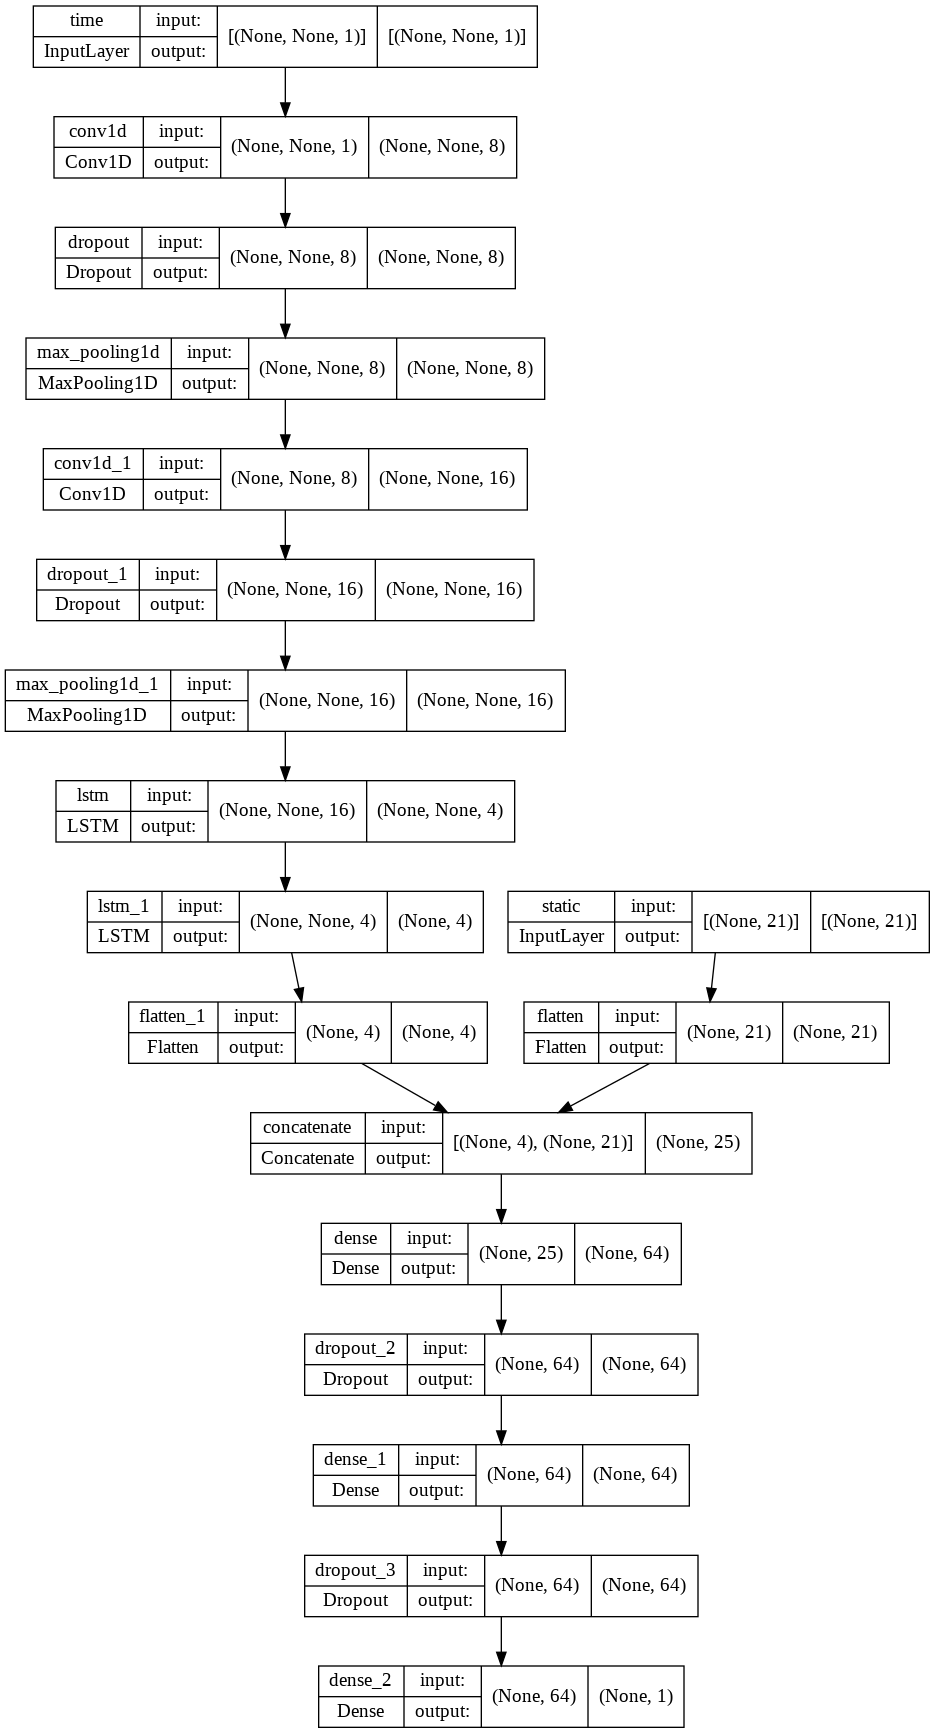

In [ ]:
K.clear_session()

def create_time_model(filter_units = 16, lstm_units = 4, kernel_size = 4, dense_units = 64, dr = .2 ):
    input0 = Input(shape = (21,), name = 'static')
    input1 = Input(shape = (None,1), name = 'time')
    y = Flatten()(input0)
    x = conv_block(input1,filter_units, kernel_size, dr)                                                            
    x = lstm_block(x, lstm_units, dr)
    x = Flatten()(x)
    x = Concatenate(axis=-1)([x, y])
    x = dense_block(x, dense_units, dr)
    out = Dense(1)(x)
    model = Model(inputs = [input0,input1], outputs = out)

    return model

model = create_time_model()
model.compile(loss = create_smape(), optimizer = 'adam', metrics = ['mape', create_smape(threshold = 0)])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
early_stopping = EarlyStopping(patience = 3, restore_best_weights= True)
history = model.fit({'static':train_static, 'time':train_time}, validation_data = {'static':valid_static, 'time':valid_time}, 
                    shuffle = True, epochs = 20, callbacks = early_stopping)

ValueError: ignored

In [ ]:
def plot_model_perf(history, metric = None):
  plt.subplots(len([metric]), 1, figsize=(12, 8))
  epochs = range(len(history.history['loss']))
  plt.plot( epochs, history.history['loss'],color = 'blue', label = 'loss' )
  plt.plot(epochs, history.history['val_loss'], color = 'red', label = 'val_loss' )
  plt.legend()
  plt.show()
  if metric:
    for i, metric in enumerate(metric):
      plt.figure(figsize=(12, 8))
      plt.plot( epochs, history.history[f'{metric}'],color = 'green', label = f'{metric}' )
      plt.plot(epochs, history.history[f'val_{metric}'], color = 'orange', label = f'val_{metric}' )
      plt.legend()
      plt.show()

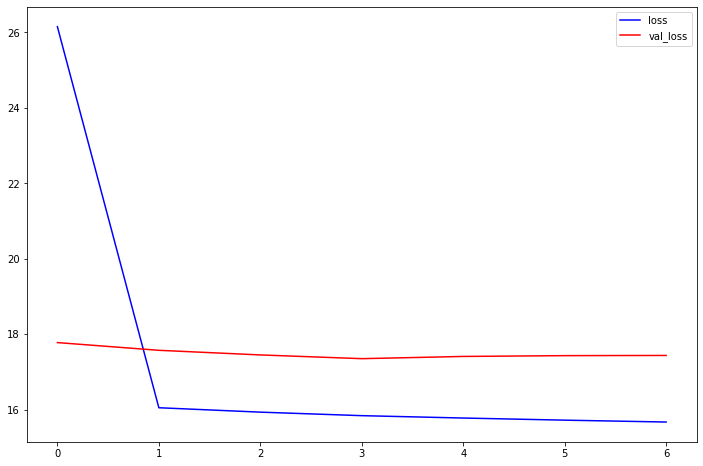

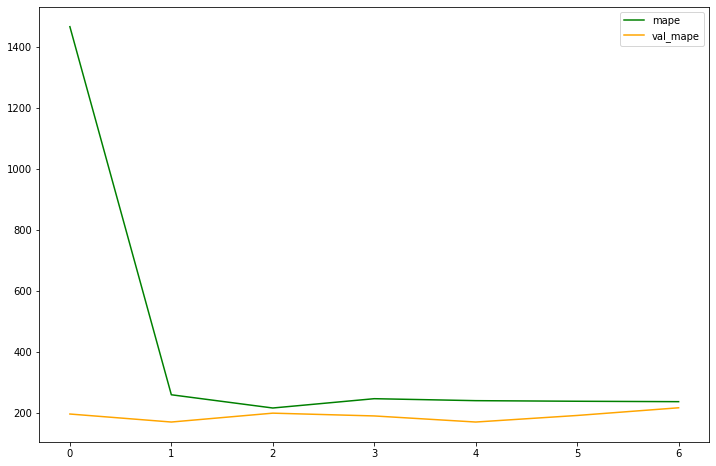

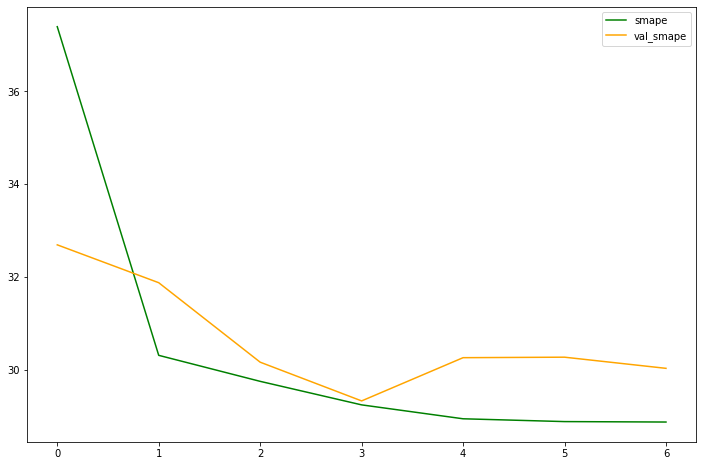

213/213 [==============================] - 22s 19ms/step - loss: 17.3487 - mape: 190.7276 - smape: 29.3305


[17.34870147705078, 190.72763061523438, 29.330455780029297]

In [ ]:
plot_model_perf(history, ['mape', 'smape'])
model.evaluate(valid)

In [ ]:
model.evaluate(valid)

213/213 [==============================] - 21s 18ms/step - loss: 17.3487 - mape: 190.7276 - smape: 29.3305


[17.34870147705078, 190.72763061523438, 29.330455780029297]

In [ ]:
def window_for_eval(data, window_size = g.window_size, batch_size = len(data)-g.batch_size+1):
  dataset = tf.data.Dataset.from_tensor_slices(np.asarray(data))
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1,-1]))
  dataset = dataset.batch(batch_size)
  return dataset

In [ ]:
def plot_predictions(data, dict_number, model = model):
  plt.figure(figsize = (20, 8))
  test_batch = window_for_eval(data[dict_number])  
  xbatch, ybatch = iter(test_batch).get_next()
  test_pred = model.predict(test_batch)
  vline = np.linspace(0, test_pred.shape[0], test_pred.shape[0])
  plt.plot(vline, test_pred.reshape(-1), color = 'red', label = 'Prediction')
  plt.plot(vline, ybatch.numpy().reshape(-1), color = 'green', label = 'Actual')
  plt.title(f'Prediction vs. actual for validation dataset {dict_number}')
  plt.xlabel("Week")
  plt.ylabel("Value")
  plt.legend()
  plt.show()

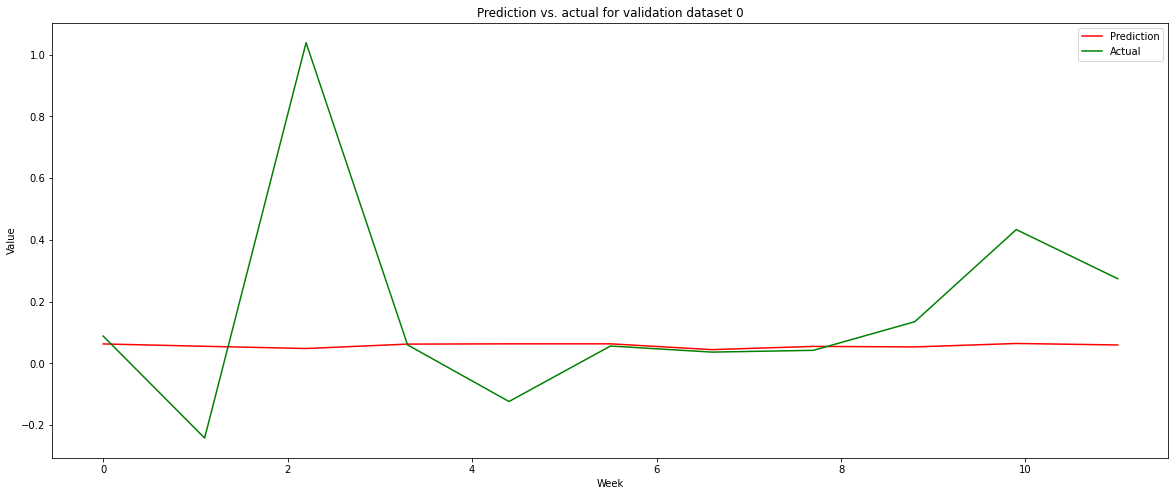

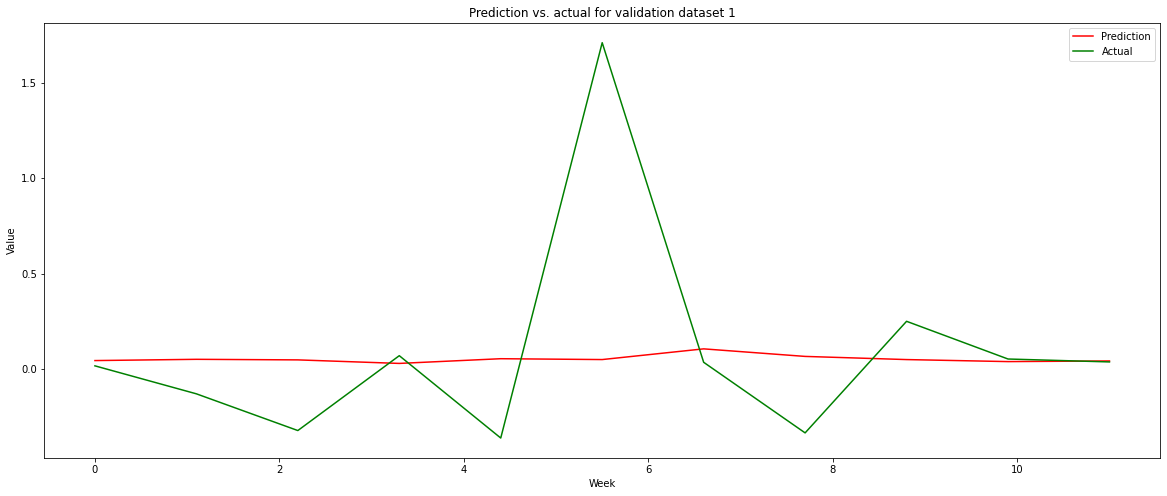

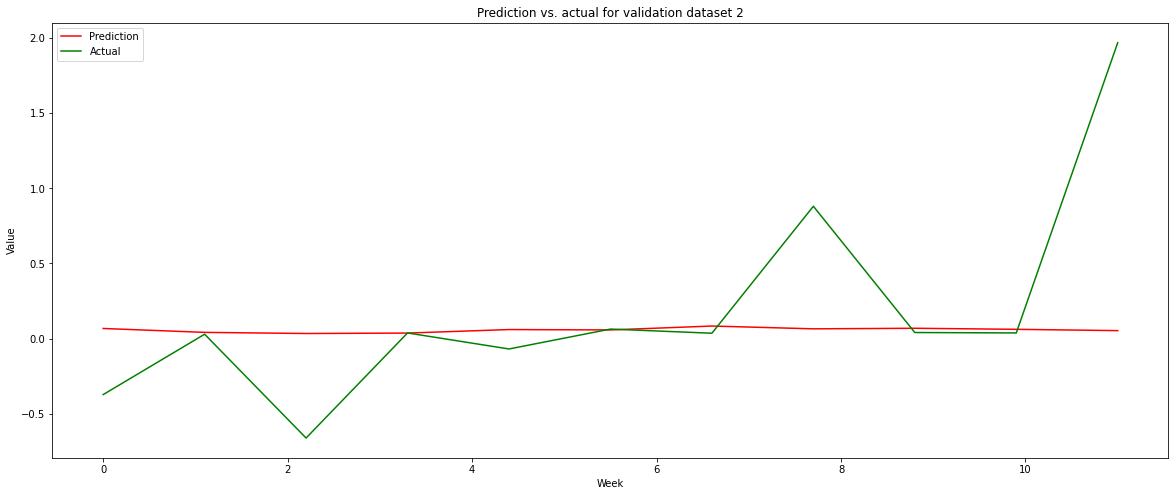

In [ ]:
for i in range(0, 3):
  plot_predictions(valid_scaled, i)

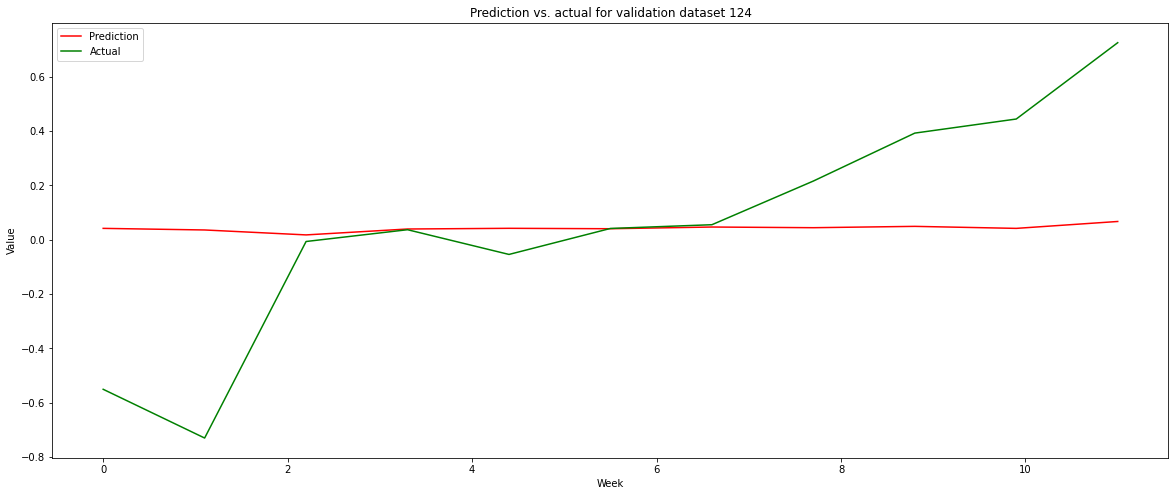

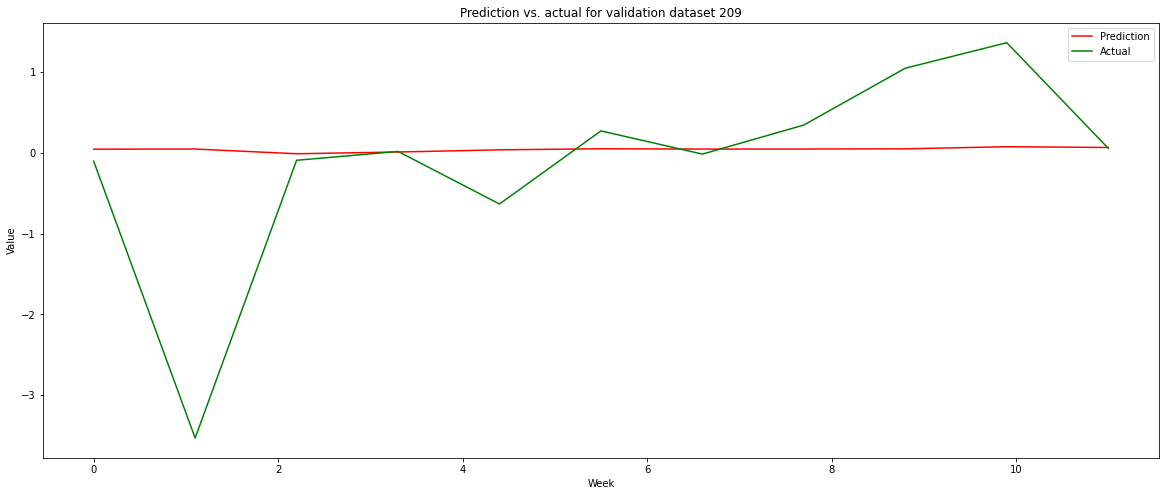

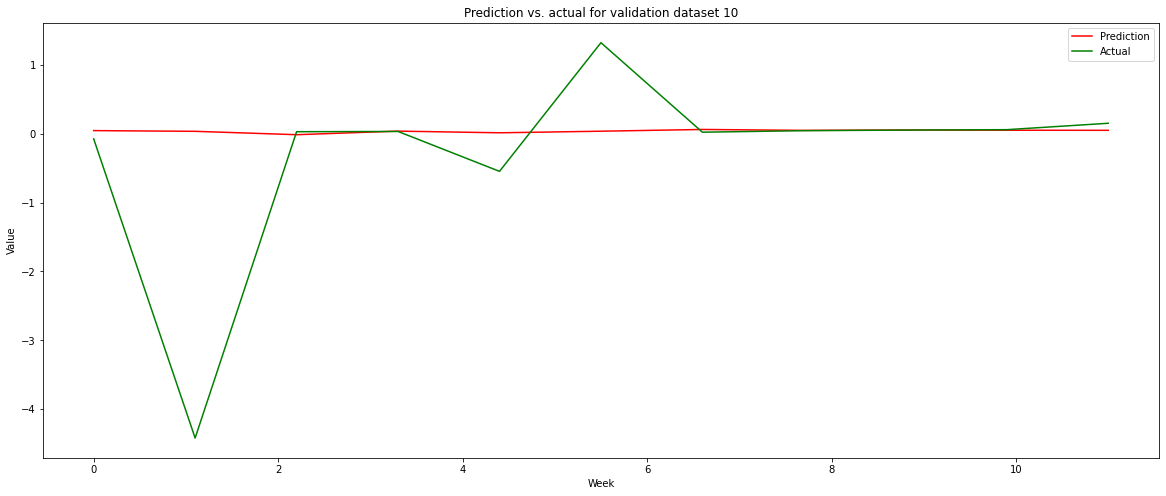

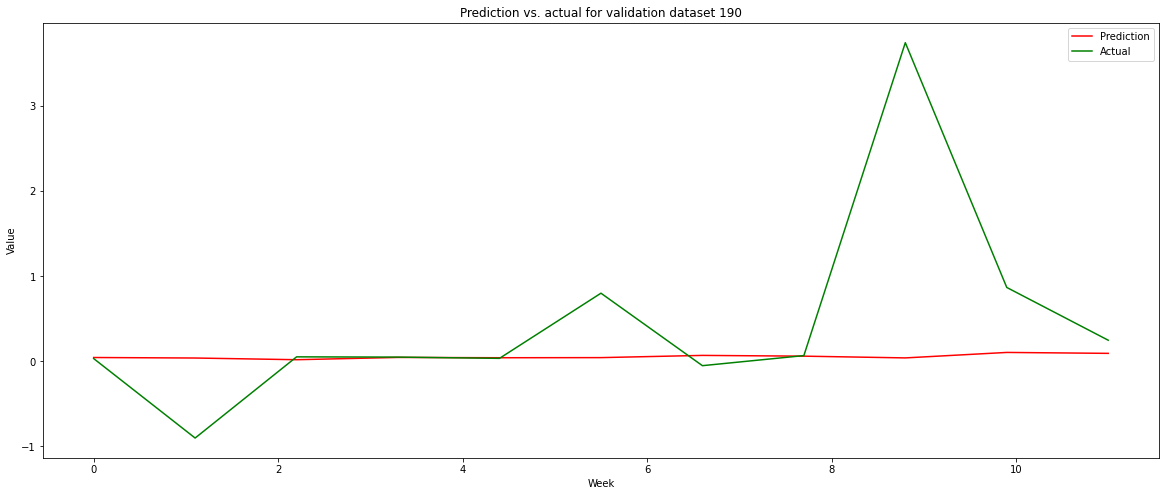

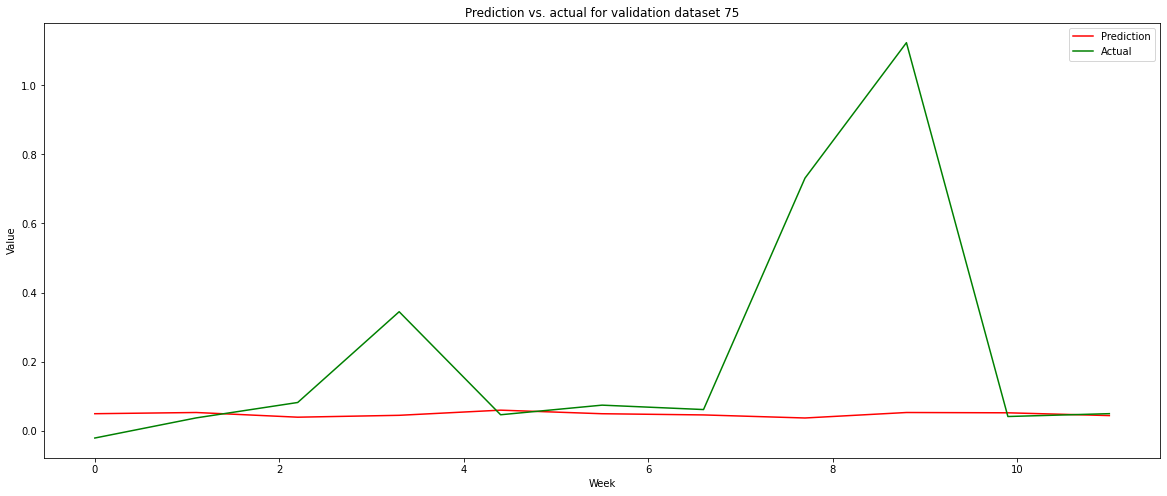

In [ ]:
for i in range(0,5):
  plot_predictions(valid_scaled, np.random.randint(0, len(valid_scaled)))